# Objectif du projet : Génération de données financières réalistes via réseaux de neurones récurrents (LSTM) pour l'entraînement et la simulation de stratégies de trading
---
Pour ce projet nous avons le dataset suivant : <link>https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data</link>



### Code

In [1]:
# from google.cloud import storage
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import cycle
import shutil
!pip install tqdm

### Analyse et transformation

#### Extract Data

In [2]:
# --- CONFIGURATION ---
# PROJECT_ID = "bitcoin-analytics-458014"
# BUCKET_NAME = f"{PROJECT_ID}-data-bucket"
# GCS_SOURCE_PATH = f"gs://{BUCKET_NAME}/from-git/data/btcusd_1-min_data.csv"
# file_path = "from-git/data/btcusd_1-min_data.csv"


# # Client Google Cloud storage
# client = storage.Client()
# bucket = client.get_bucket(BUCKET_NAME)
# blob = bucket.blob(file_path)

# # Lecture du dataframe
# data = blob.download_as_bytes()
shutil.copy("/home/dataset-bitcoin/btcusd_1-min_data.csv", "/content/btcusd_1-min_data.csv")
df = pd.read_csv("/content/btcusd_1-min_data.csv")
# Afficher les infos du dataframe
print(df.info())
# df = pd.read_csv(pd.io.common.BytesIO(data))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652248 entries, 0 to 652247
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  652248 non-null  float64
 1   Open       652247 non-null  float64
 2   High       652247 non-null  float64
 3   Low        652247 non-null  float64
 4   Close      652247 non-null  float64
 5   Volume     652247 non-null  float64
dtypes: float64(6)
memory usage: 29.9 MB
None


#### Change Timestamp type to Datetime

In [3]:
# Vérifier les dates min et max du dataframe
if 'Timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df.drop(columns=['Timestamp'])

print(f'Premiere lignes :{df.head()}')
print(f'Derniere lignes :{df.tail()}')


Premiere lignes :   Open  High   Low  Close  Volume           timestamp
0  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:01:00
1  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:02:00
2  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:03:00
3  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:04:00
4  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:05:00
Derniere lignes :        Open  High   Low  Close  Volume           timestamp
652243  90.1  90.1  90.1   90.1     0.0 2013-03-29 08:44:00
652244  90.1  90.1  90.1   90.1     0.0 2013-03-29 08:45:00
652245  90.1  90.1  90.1   90.1     0.0 2013-03-29 08:46:00
652246  90.1  90.1  90.1   90.1     0.0 2013-03-29 08:47:00
652247   NaN   NaN   NaN    NaN     NaN 1970-01-01 00:00:13


#### Vérifier les valeurs null et absente

In [4]:
print(f'Nombres de valeurs null : {df.isnull().values.sum()} et NA : {df.isnull().values.any()}')

Nombres de valeurs null : 5 et NA : True


In [5]:
# Afficher les colonnes avec valeurs nulles
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]

null_counts

,0
Open,1
High,1
Low,1
Close,1
Volume,1


In [6]:
# Supprimer la dernière ligne si elle est entièrement vide (valeurs corrompues)
df.dropna(how='all', inplace=True)
df.dropna(inplace=True)
print(f"Nouvelles valeurs nulles : {df.isnull().sum().sum()}")


Nouvelles valeurs nulles : 0


#### Analyse des données d'une seul année

In [9]:
# Filtrage sur 1 année entiere

def filter_year(df, year):
    start = pd.Timestamp(f"{year}-01-01")
    end = pd.Timestamp(f"{year + 1}-01-01")
    return df[(df['timestamp'] >= start) & (df['timestamp'] < end)]

df_filtered_by_year = filter_year(df, 2012)
df_filtered_by_year = df_filtered_by_year[df_filtered_by_year['Volume'] > 0]

df_filtered_by_year.reset_index(drop=True, inplace=True) # Reset les index a partir de 0
print(f'total value pour l\année : {df_filtered_by_year.shape[0]}')
df_filtered_by_year.head()

total value pour lnnée : 26611


,Open,High,Low,Close,Volume,timestamp
0,4.84,4.84,4.84,4.84,10.000000,2012-01-01 20:28:00
1,5.00,5.00,5.00,5.00,10.100000,2012-01-02 03:45:00
2,5.00,5.00,5.00,5.00,19.048000,2012-01-03 01:04:00
3,5.32,5.32,5.32,5.32,2.419173,2012-01-03 16:45:00
4,5.14,5.14,5.14,5.14,0.680000,2012-01-03 19:22:00


In [10]:
# Avoir une moyenne sur chaque mois de chaque colonne
monthvise = df_filtered_by_year.groupby(df_filtered_by_year['timestamp'].dt.strftime('%B'))[['Open','High','Close','Volume','Low']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
# Supprimer les lignes vides (mois sans données)
monthvise.dropna(how='all', inplace=True)
monthvise

,Open,High,Close,Volume,Low
timestamp,,,,,
January,6.356861,6.360483,6.357626,4.048800,6.352656
February,5.231252,5.232696,5.229548,8.281059,5.228070
March,4.985678,4.986884,4.984037,15.158503,4.982797
April,4.995046,4.996321,4.994954,21.661193,4.993640
May,5.045736,5.046246,5.045400,21.460143,5.044925
June,6.037905,6.039672,6.038080,31.688963,6.036333
July,7.892432,7.895895,7.893182,19.803042,7.889676
August,10.983654,10.990081,10.980677,21.006255,10.974589
September,11.427596,11.430196,11.427746,17.222483,11.425152


In [11]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index[:300],  # Limite à 300 valeurs de l'index
    y=monthvise['Open'][:300],  # Limite aussi les valeurs associées
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index[:300],
    y=monthvise['Close'][:300],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(
    barmode='group',
    xaxis_tickangle=-45,
    title='Monthwise comparison between Stock Open, Close Price and Stock High'
)

fig.show()


In [27]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

# limiter à 300 valeurs
df_limited = df_filtered_by_year[:10000]
fig = px.line(df_limited, x=df_limited.timestamp, y=[df_limited['Open'], df_limited['Close'],
                                          df_limited['High'], df_limited['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### Construction du modèle LSTM

<li>1ere étape : Préparation des données d'entrainement et de test </li>
<li>Nous voulons prédire à partir de données historique, les données de l'année suivante dont (Open, High, Low, Close, Volume)</li>

In [28]:
# Récupération des features Close, Volume
features = ['Close']
df_for_prediction = df_filtered_by_year[features]
print(df_for_prediction.shape)
df_for_prediction.head()

(26611, 1)


,Close
0,4.84
1,5.00
2,5.00
3,5.32
4,5.14


#### Normalisation des features

In [30]:
# On utilise la méthode MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(scaled_data).reshape(-1,1))
# Affichage des 5 premieres lignes du tableau
print(scaled_data.shape)
scaled_data[:5]

(53222, 1)


array([[0.0852459 ],
       [0.00338012],
       [0.09836066],
       [0.00341392],
       [0.09836066]])

#### Division des features en données d'entrainement et de test

In [31]:
# On utilisera 80% de données d'entrainement et 20% de données de test
split = int(0.8 * len(scaled_data))
trained_data = scaled_data[:split]
test_data = scaled_data[split:]

print(f'train : {trained_data.shape}, test: {test_data.shape}')
print(trained_data[:5])

train : (42577, 1), test: (10645, 1)
[[0.0852459 ]
 [0.00338012]
 [0.09836066]
 [0.00341392]
 [0.09836066]]


#### Préparation des séquences temporelles pour l'entraînement du modèle

<li>Pour entraîner un modèle LSTM sur des données de marché (OHLCV), nous devons transformer notre série temporelle multivariée en séquences d’entrée/sortie. Chaque entrée contiendra `60` minutes consécutives d’observations, et la sortie sera la minute suivante.</li>
<li>La fonction ci-dessous permet de générer ces paires `X` (séquences) et `y` (prédictions) :</li>


In [32]:
# Fonction pour crée les séquences X et y
def create_dataset_multivariate(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, :])       # Séquence de 60 lignes × 5 colonnes
        y.append(dataset[i + time_step, :])         # La ligne suivante entière (5 colonnes)
    return np.array(X), np.array(y)

In [33]:
seq_length = 60  # 1 min

X_train, y_train = create_dataset_multivariate(trained_data, seq_length)
X_test, y_test = create_dataset_multivariate(test_data, seq_length)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (42457, 120, 1)
X_test : (10525, 120, 1)


In [34]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (42457, 120, 1)
X_test:  (10525, 120, 1)


#### Construction du modele

In [35]:
model = Sequential([
    Input(shape=(seq_length, trained_data.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(trained_data.shape[1])  # ex : 2 sorties pour Close et Volume
])

# Fonction callback
early_stop = EarlyStopping(
    monitor='loss',
    patience=8,        # stop après 8 epochs sans amélioration
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='mae',  metrics=['mae'])

#### Entrainement du modele

In [36]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, verbose=1, batch_size=64)

Epoch 1/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.2291 - mae: 0.2291 - val_loss: 0.3593 - val_mae: 0.3593
Epoch 2/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0980 - mae: 0.0980 - val_loss: 0.0071 - val_mae: 0.0071
Epoch 3/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 4/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0099 - mae: 0.0099 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 5/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 6/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0084 - mae: 0.0084 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 7/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0085 - mae: 0.0085 - val_loss: 0.0092 - val_mae: 0.0092
Epoch 8/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0086 - mae: 0.0086 - val_loss: 0.0067 - val_mae: 0.0067
Epoch 9/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 

#### Visualiser l'apprentissage (courbe loss vs val loss)

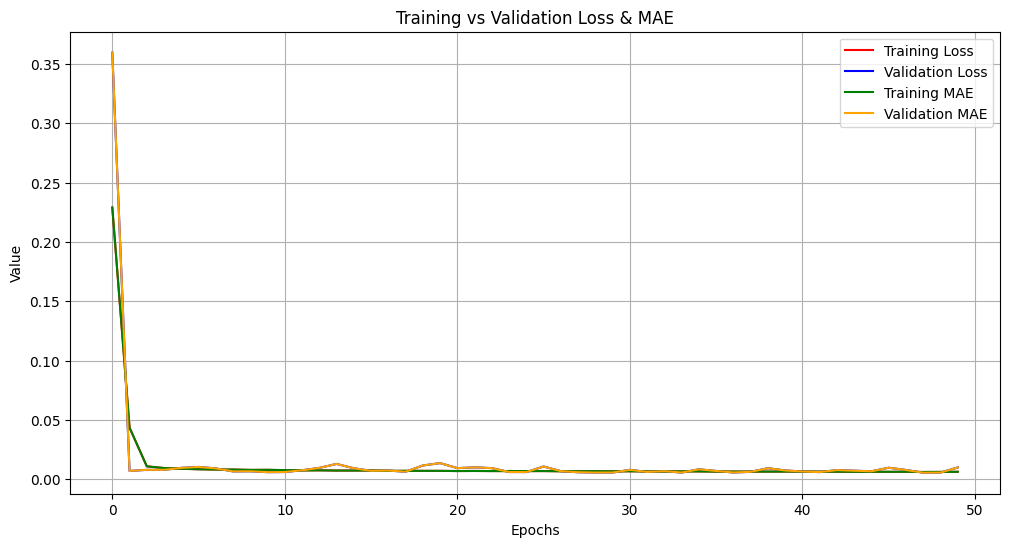

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(len(loss))

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs, mae, 'g', label='Training MAE')
plt.plot(epochs, val_mae, 'orange', label='Validation MAE')
plt.title('Training vs Validation Loss & MAE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


#### Evaluation du modèle

In [38]:
# Prédiction du modèle avec X_test
y_pred = model.predict(X_test)
y_pred.shape


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


(10525, 1)

#### Transformation des données normaisé dans leur formes originales

In [39]:
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

#### Calcul du r2 score

In [40]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred_original)
print(f"R² score : {r2:.4f}")


R² score : 0.9978


#### Comparaison prédiction vs réalité

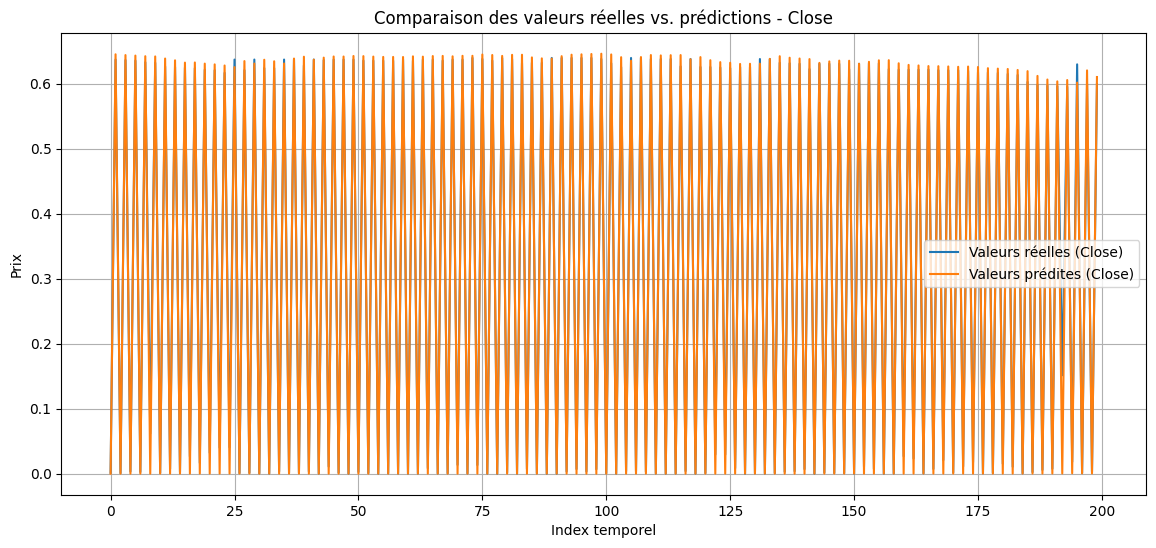

In [41]:
plt.figure(figsize=(14, 6))

# -- Courbe Close
plt.plot(y_test_original[:200, 0], label='Valeurs réelles (Close)')
plt.plot(y_pred_original[:200, 0], label='Valeurs prédites (Close)')
plt.title("Comparaison des valeurs réelles vs. prédictions - Close")
plt.xlabel("Index temporel")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
model.save("bitcoin_lstm_model.h5")

from google.colab import files
files.download("bitcoin_lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 120, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,421 (1.48 MB)

 Trainable params: 129,473 (505.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 258,948 (1011.52 KB)

### Prédire les 30 prochains jours de 2013 à partir des 15 dernier jours

In [47]:
from tqdm import tqdm
import numpy as np

# Dernière séquence de 30 minutes connue (30 lignes × 5 colonnes)
current_sequence = [row.tolist() for row in scaled_data[-30:]]
future_predictions = []

minutes_per_day = 1440
days_to_predict = 30

print("🚀 Début de la génération des 30 prochains jours...")

for day in range(days_to_predict):
    print(f"\n📅 Génération du jour {day + 1}/{days_to_predict}...")

    for i in tqdm(range(minutes_per_day), desc=f"Jour {day + 1}", ncols=100):
        input_seq = np.array(current_sequence[-30:]).reshape((1, 30, 1))

        next_pred = model.predict(input_seq, verbose=0)[0]

        # Sécurise l'ajout de la prédiction comme liste
        current_sequence.append(list(next_pred))
        future_predictions.append(next_pred)

print(f"\n✅ Génération terminée. Total de prédictions : {len(future_predictions)}")


🚀 Début de la génération des 30 prochains jours...

📅 Génération du jour 1/30...


Jour 1: 100%|███████████████████████████████████████████████████| 1440/1440 [01:40<00:00, 14.36it/s]



📅 Génération du jour 2/30...


Jour 2: 100%|███████████████████████████████████████████████████| 1440/1440 [01:42<00:00, 14.06it/s]



📅 Génération du jour 3/30...


Jour 3: 100%|███████████████████████████████████████████████████| 1440/1440 [01:42<00:00, 14.08it/s]



📅 Génération du jour 4/30...


Jour 4: 100%|███████████████████████████████████████████████████| 1440/1440 [01:42<00:00, 14.10it/s]



📅 Génération du jour 5/30...


Jour 5: 100%|███████████████████████████████████████████████████| 1440/1440 [01:43<00:00, 13.95it/s]



📅 Génération du jour 6/30...


Jour 6: 100%|███████████████████████████████████████████████████| 1440/1440 [01:41<00:00, 14.13it/s]



📅 Génération du jour 7/30...


Jour 7: 100%|███████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.77it/s]



📅 Génération du jour 8/30...


Jour 8: 100%|███████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.81it/s]



📅 Génération du jour 9/30...


Jour 9: 100%|███████████████████████████████████████████████████| 1440/1440 [01:43<00:00, 13.89it/s]



📅 Génération du jour 10/30...


Jour 10: 100%|██████████████████████████████████████████████████| 1440/1440 [01:45<00:00, 13.65it/s]



📅 Génération du jour 11/30...


Jour 11: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.82it/s]



📅 Génération du jour 12/30...


Jour 12: 100%|██████████████████████████████████████████████████| 1440/1440 [01:45<00:00, 13.59it/s]



📅 Génération du jour 13/30...


Jour 13: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.75it/s]



📅 Génération du jour 14/30...


Jour 14: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.78it/s]



📅 Génération du jour 15/30...


Jour 15: 100%|██████████████████████████████████████████████████| 1440/1440 [01:46<00:00, 13.58it/s]



📅 Génération du jour 16/30...


Jour 16: 100%|██████████████████████████████████████████████████| 1440/1440 [01:43<00:00, 13.98it/s]



📅 Génération du jour 17/30...


Jour 17: 100%|██████████████████████████████████████████████████| 1440/1440 [01:47<00:00, 13.44it/s]



📅 Génération du jour 18/30...


Jour 18: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.73it/s]



📅 Génération du jour 19/30...


Jour 19: 100%|██████████████████████████████████████████████████| 1440/1440 [01:45<00:00, 13.70it/s]



📅 Génération du jour 20/30...


Jour 20: 100%|██████████████████████████████████████████████████| 1440/1440 [01:46<00:00, 13.53it/s]



📅 Génération du jour 21/30...


Jour 21: 100%|██████████████████████████████████████████████████| 1440/1440 [01:43<00:00, 13.85it/s]



📅 Génération du jour 22/30...


Jour 22: 100%|██████████████████████████████████████████████████| 1440/1440 [01:47<00:00, 13.40it/s]



📅 Génération du jour 23/30...


Jour 23: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.81it/s]



📅 Génération du jour 24/30...


Jour 24: 100%|██████████████████████████████████████████████████| 1440/1440 [01:46<00:00, 13.51it/s]



📅 Génération du jour 25/30...


Jour 25: 100%|██████████████████████████████████████████████████| 1440/1440 [01:46<00:00, 13.57it/s]



📅 Génération du jour 26/30...


Jour 26: 100%|██████████████████████████████████████████████████| 1440/1440 [01:44<00:00, 13.73it/s]



📅 Génération du jour 27/30...


Jour 27: 100%|██████████████████████████████████████████████████| 1440/1440 [01:47<00:00, 13.38it/s]



📅 Génération du jour 28/30...


Jour 28: 100%|██████████████████████████████████████████████████| 1440/1440 [01:43<00:00, 13.93it/s]



📅 Génération du jour 29/30...


Jour 29: 100%|██████████████████████████████████████████████████| 1440/1440 [01:48<00:00, 13.30it/s]



📅 Génération du jour 30/30...


Jour 30: 100%|██████████████████████████████████████████████████| 1440/1440 [01:45<00:00, 13.67it/s]


✅ Génération terminée. Total de prédictions : 43200


In [48]:
future_predictions[:5]


[array([0.77376306], dtype=float32),
 array([-0.00013281], dtype=float32),
 array([0.7722472], dtype=float32),
 array([-0.00010801], dtype=float32),
 array([0.77125084], dtype=float32)]

In [51]:
# Conversion en tableau numpy
pred_array = np.array(future_predictions)

# (Retour à l'échelle d'origine)
pred_close = scaler.inverse_transform(pred_array)

# Générer une colonne datetime pour 30 jours à partir de la dernière date connue
last_timestamp = df_filtered_by_year['timestamp'].max()
timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=1), periods=len(pred_close), freq='T')

# Création du DataFrame
df_predictions = pd.DataFrame({
    'timestamp': timestamps,
    'predicted_close': pred_close.flatten()
})

df_predictions.tail()

<ipython-input-51-9fbe685223f0>:9: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



,timestamp,predicted_close
43195,2013-01-30 23:48:00,-0.000132
43196,2013-01-30 23:49:00,0.759757
43197,2013-01-30 23:50:00,-0.000132
43198,2013-01-30 23:51:00,0.759757
43199,2013-01-30 23:52:00,-0.000132
